In [1]:
# py -m poetry config virtualenvs.in-project true
# py -m poetry init -n
# py -m poetry add numpy matplotlib scipy pandas bokeh statsmodels
# py -m poetry add ipykernel
from typing import Optional
import pickle
import itertools
from pathlib import Path

import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import pandas as pd 
import matplotlib.colors as mcolors
from matplotlib.cm import get_cmap


%load_ext autoreload
%autoreload 2

In [2]:
THIS_PATH = Path.cwd()
TMP_PATH = THIS_PATH.joinpath("tmp")
TMP_PATH.mkdir(parents=True, exist_ok=True)
RESULTS_PATH = THIS_PATH.joinpath("results")
RESULTS_PATH.mkdir(parents=True, exist_ok=True)
NORMAL_FONTSIZE = 20
RANDOM_SEED = 17
NP_SEED = 123

In [3]:

def model(x, b0, b1):
    # two-parameter model.
    return b1 * x + b0

def make_data():

    np.random.seed(NP_SEED)

    # Intercept
    b0 = 0

    # Slopes
    b1 = [-5, 5]

    # Noise
    sigma = 2

    # Sizes
    size1 = 125
    size2 = 135
    
    size = size1 + size2

    print("Total number of data points", size1 + size2)
    print(f"Weight cmp1: {size1 / size:.2f}" )
    print(f"Weight cmp2: {size2 / size:.2f}")

    # Predictor variable
    X1_1 = np.linspace(-2, 2, size1)
    # Simulate outcome variable--cluster 1
    Y1 = model(X1_1, b0, b1[0]) + np.random.normal(loc=0, scale=sigma, size=size1)

    # Predictor variable
    X1_2 = np.linspace(-3, 3, size2)
    # Simulate outcome variable --cluster 2
    Y2 = model(X1_2, b0, b1[1]) + np.random.normal(loc=0, scale=sigma, size=size2)

    return b0, b1, sigma, X1_1, X1_2, Y1, Y2


In [4]:
b0, b1, sigma, x1, x2, y1, y2 = make_data()

# joint data set with anonymous classes
x = np.append(x1, x2)
y = np.append(y1, y2)

Total number of data points 260
Weight cmp1: 0.48
Weight cmp2: 0.52


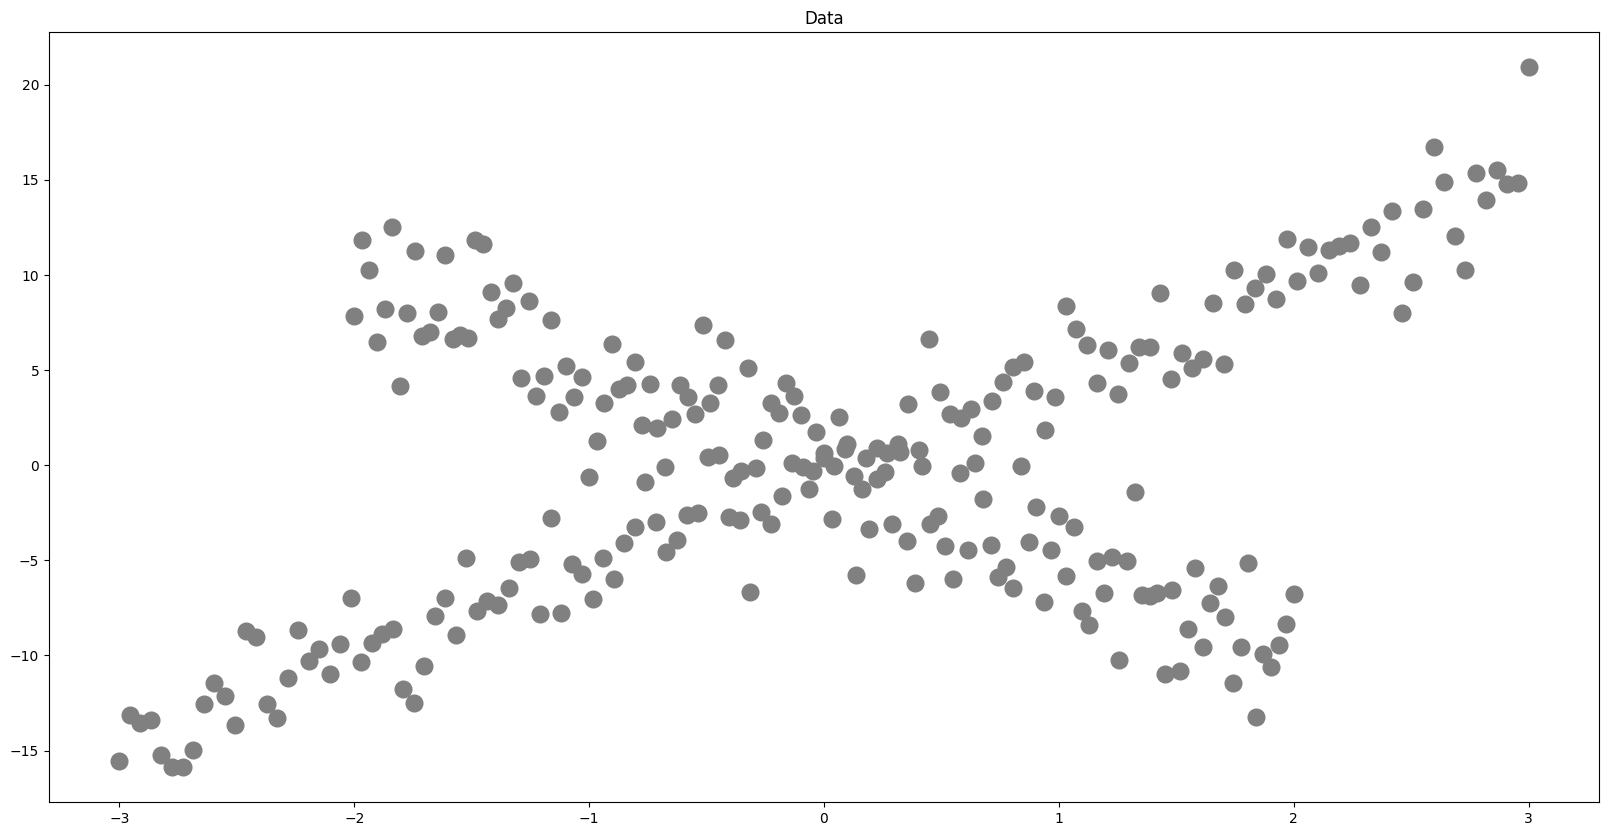

In [5]:
def plot_data(xs, ys):
    fig, ax = plt.subplots(1, 1, figsize=(20, 10))
    ax.set_title("Data")
    for x, y in zip(xs, ys):
        ax.scatter(
            x,
            y,
            s=144,
            marker="o",
            color="gray",
        )
    plt.close()
    return fig

fig = plot_data((x1, x2), (y1, y2))
fig

In [ ]:
import copy 
import collections

def model(x, b0, b1):
    return b0 + b1 * x

def yerr_sq(x, y, *pars):
    return np.pow(model(x, *pars) - y, 2)

def get_log_likelihood(x, y, par):
    # # log likelihood for all data points
    # rss = np.sum(yerr_sq(x, y, *par))
    # # sigma_sq = rss / (len(y) - len(par))
    # sigma_sq = rss / len(y)

    # # log-likelihood
    # npoints = len(y)
    # ll = -0.5 * npoints * np.log(2 * np.pi * sigma_sq) - rss / (2 * sigma_sq)
    # return ll
    return np.sum(get_log_likelihoods(x, y, par))

def get_log_likelihoods(x, y, par):
    # log likelihood for each data point
    rss = yerr_sq(x, y, *par)
    # sigma_sq = np.sum(rss) / (len(y) - len(par))
    sigma_sq = np.sum(rss) / len(y)

    # https://www.statlect.com/fundamentals-of-statistics/normal-distribution-maximum-likelihood
    # log-likelihood for each point
    npoints = 1
    ll = -0.5 * npoints * np.log(2 * np.pi * sigma_sq) - rss / (2 * sigma_sq)
    return ll


def get_membership(x, y, pars):

    # RSS of all points for each model
    lls = np.exp(
        [get_log_likelihoods(x, y, par) for par in pars if par is not None]
    )
    assert len(lls) > 0, f"{pars}"

    p_membership = lls / np.sum(lls, axis=0)

    # For each datapoint get index of the line to which the datapoint is closest
    idxmodel = np.argmax(p_membership, axis=0)

    # if sigma_sq is not None:
    #     errsq = errsq / sigma_sq

    # For each datapoint get index of the line to which the datapoint is closest
    return idxmodel, p_membership

def split_data(x, y, pars):
    membership, _ = get_membership(x, y, pars)
    nmodels = len(pars)

    x_at_idxmod = []
    y_at_idxmod = []
    for idx_model in range(nmodels):
        mask = membership == idx_model
        x_at_idxmod.append(x[mask])
        y_at_idxmod.append(y[mask])
    
    return x_at_idxmod, y_at_idxmod

# select two points at random for each model 
def get_p0(nmodels, npoints=2):
    """
    Args:
        nmodels: Total number of models we want to initialize 
            parameters for.
        npoints: The number of points to use when initializing each 
            model. 
    """
    p0 = []
    idxs = np.split(np.random.randint(0, len(x), npoints*nmodels), nmodels)
    for _idxs in idxs:
        xinit = x[_idxs]
        yinit = y[_idxs]
        popt, _ = curve_fit(model, xinit, yinit)
        p0.append(popt)

    return p0


def _fit_lines(x, y, pars, sigma_sq=None):
    membership, _ = get_membership(x, y, pars)

    # With the memberships fit models
    nmodels = len(pars)
    popts = []
    rss_sum = 0.0
    for idx_model in range(nmodels):
        mask = membership == idx_model
        if pars[idx_model] is None or len(x[mask]) < len(pars[idx_model]):
            # too few data points to fit
            popts.append(None)
            return popts, np.inf
        popt, pcov, infodict, msg, ier = curve_fit(model, x[mask], y[mask], p0=pars[idx_model], full_output=True)
        # if ier not in [1,2,3,4]:
        #     print(ier, msg)
        rss = np.sum(yerr_sq(x[mask], y[mask], *popt))
        rss_sum += rss
        # sigma_sq = rss / (len(x[mask]) - len(popt))
        popts.append(popt.tolist())

    return popts, rss_sum

def fit_lines_one_seed(x, y, p0, nmax):
    popts, rss = _fit_lines(x, y, p0)
    # print(f"Initial: {rss} ({popts})")

    if None in popts:
        membership, _ = get_membership(x, y, p0)
        # print("X"*50)
        # print(membership)
        # print(collections.Counter(membership))
        return p0, np.inf

    popts_min = copy.copy(popts)
    rss_min = rss
    rss_prev = rss
    for i in range(nmax):
        popts, rss = _fit_lines(x, y, popts)
        if None in popts:
            # membership, _ = get_membership(x, y, p0)
            # print("X"*50)
            # print(membership)
            # print(collections.Counter(membership))
            # One component missing data so break out without saving the parameters
            break
        # print(f"Candidate ({i}): {rss_min} -> {rss} ({popts})")
        if rss < rss_min:
            # print(f"Update ({i}): {rss_min} -> {rss} ({popts})")
            popts_min = copy.copy(popts)
            rss_min = rss
        elif rss == rss_prev:
            # Converged
            break
        rss_prev = rss
    
    # ptmp = np.array(popts_min)
    # print(f"Optimal (ncomp={ptmp.shape[0]}): rss={rss_min} (popt={ptmp}) (nsteps={i})")
    return popts_min, rss_min


def fit_lines(x, y, p0, nmodels, nseed=25, nmax=250):

    if p0 is None:
        # npoints is the number of data points used to estimate p0 for each component 
        # npoints = len(x) // nmodels
        npoints = 2
        popt_min = None
        rss_min = 1e9
        for _ in range(nseed):
            _p0 = get_p0(nmodels, npoints=npoints)
            popt, rss_opt = fit_lines_one_seed(x, y, _p0, nmax)

            if not np.any(popt == None) and rss_opt < rss_min:
                popt_min = popt
                rss_min = rss_opt
        return popt_min
    else:
        popt, _ = fit_lines_one_seed(x, y, p0, nmax)
        return popt 




In [327]:
nmodels = 5
# npoints = len(x) // nmodels
# p0 = get_p0(nmodels, npoints=npoints)
# print(p0)

In [330]:
ncomp = []
lls = []
bics = []
aics = []
pars_all_models = []
specificity_gain = []
for icomp in range(1, nmodels +1):
    print(f"Trying {icomp} component model")
    ncomp.append(icomp)
    pars = fit_lines(x, y, None, nmodels=icomp)

    xsplit, ysplit = split_data(x, y, pars)

    ll_tot = 0.0
    npar = 0
    for j, (_x, _y, _par) in enumerate(zip(xsplit, ysplit, pars)):
        # print(_y)
        # print(len(_par))
        idx_membership, p_membership = get_membership(x, y, pars)
        if _par is None or len(_x) < len(_par) or _par is None:
            print(f"Data points in component {j} is {len(_x)} which is less than the number of parameters ({len(_par)})")
            print(collections.Counter(idx_membership))
            ll_tot = np.inf
            npar = np.inf
        else:
            # print(len(_y))
            ll = get_log_likelihood(_x, _y, _par)
            ll_tot += ll
            npar += len(_par)
    lls.append(float(ll_tot))
    pars_all_models.append(pars)
    p_cat = p_membership[idx_membership, np.arange(p_membership.shape[1])]

    if np.isfinite(ll_tot):
        aic = 2 * npar - 2 * ll_tot
        bic = np.log(len(y)) * npar  -  2 * ll_tot
        print(f"{icomp}-component model ({npar} pars): AIC={aic}, BIC={bic}")
        # 1 / ncomp is the specificity if all components finds a data point equally likely i.e. 
        # we have not learned anything about the datapoint (it's random)
        sg = np.mean(p_cat) - (1.0 / ncomp[-1])
    else:
        bic = np.inf
        aic = np.inf
        sg = np.nan
        print(f"{icomp}-component model contains too little data in one or more components")
    specificity_gain.append(sg)
    bics.append(bic)
    aics.append(aic)
    print("")
 


Trying 1 component model


C:\Users\mrson\AppData\Local\Temp\ipykernel_6824\1597939856.py:81: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, _ = curve_fit(model, xinit, yinit)


1-component model (2 pars): AIC=1758.2704268000812, BIC=1765.3917900621122

Trying 2 component model


C:\Users\mrson\AppData\Local\Temp\ipykernel_6824\1597939856.py:99: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov, infodict, msg, ier = curve_fit(model, x[mask], y[mask], p0=pars[idx_model], full_output=True)


2-component model (4 pars): AIC=1263.1403070934186, BIC=1277.3830336174808

Trying 3 component model
3-component model (6 pars): AIC=1159.3836324695196, BIC=1180.7477222556129

Trying 4 component model
Data points in component 0 is 0 which is less than the number of parameters (2)
Counter({np.int64(1): 177, np.int64(3): 48, np.int64(2): 35})
4-component model contains too little data in one or more components

Trying 5 component model
5-component model (10 pars): AIC=1198.049314093233, BIC=1233.6561304033883



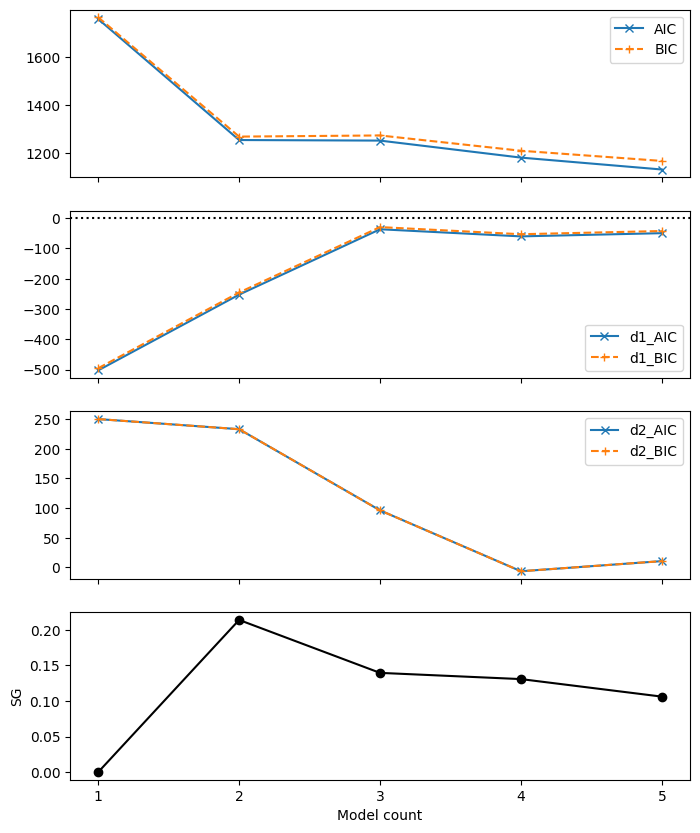

In [ ]:
import matplotlib.ticker as mticker
nmodels = len(p0)
d1_aics = np.gradient(aics)
d1_bics = np.gradient(bics)
d2_aics = np.gradient(d1_aics)
d2_bics = np.gradient(d1_bics)
fig, axs = plt.subplots(4 ,1, sharex=True, figsize=(8,10))
axs[0].plot(ncomp, aics, "-x", label="AIC")
axs[0].plot(ncomp, bics, "--+", label="BIC")
axs[1].plot(ncomp, d1_aics, "-x", label="d1_AIC")
axs[1].plot(ncomp, d1_bics, "--+", label="d1_BIC")
axs[1].axhline(linestyle=":", color="k")
axs[2].plot(ncomp, d2_aics, "-x", label="d2_AIC")
axs[2].plot(ncomp, d2_bics, "--+", label="d2_BIC")
axs[3].plot(ncomp, specificity_gain, "-ok")
axs[0].legend()
axs[1].legend()
axs[2].legend()
axs[-1].set_xlabel("Model count")
axs[-1].set_ylabel("SG")

for ax in axs:
    ax.xaxis.set_major_locator(mticker.MultipleLocator(1))

BIC values:  [np.float64(1765.3917900621118), np.float64(1266.8735971126391), np.float64(1189.2591815228807), np.float64(1194.1435260697056), np.float64(1215.3854995726472)]
AIC values [np.float64(1758.2704268000807), np.float64(1252.630870588577), np.float64(1167.8950917367874), np.float64(1165.6580730215812), np.float64(1179.778683262492)]
Best model has 4 components
[[[-0.0036473763368514434, 2.0593384579043446]], [[0.37940112390702785, -4.648535134758998], [-0.13929958910440277, 4.997640096209634]], [[-2.0158066871056555, -3.6822205337208156], [0.065535483362612, 4.915688870014899], [2.558187195989044, -3.535446571267]], [[1.9188648387510852, -3.991925454713302], [2.758675689406938, 4.3255561525026325], [-1.660863555171104, 4.406856432700724], [-2.4680914651939414, -3.8617092068420007]], [[-5.562883479373766, 1.6402977150431692], [0.6521825730162446, -5.015626371848285], [-4.507185031503843, -4.378284761370215], [6.445181820220599, 3.3366223972786018], [-0.059524176544949015, 4.824

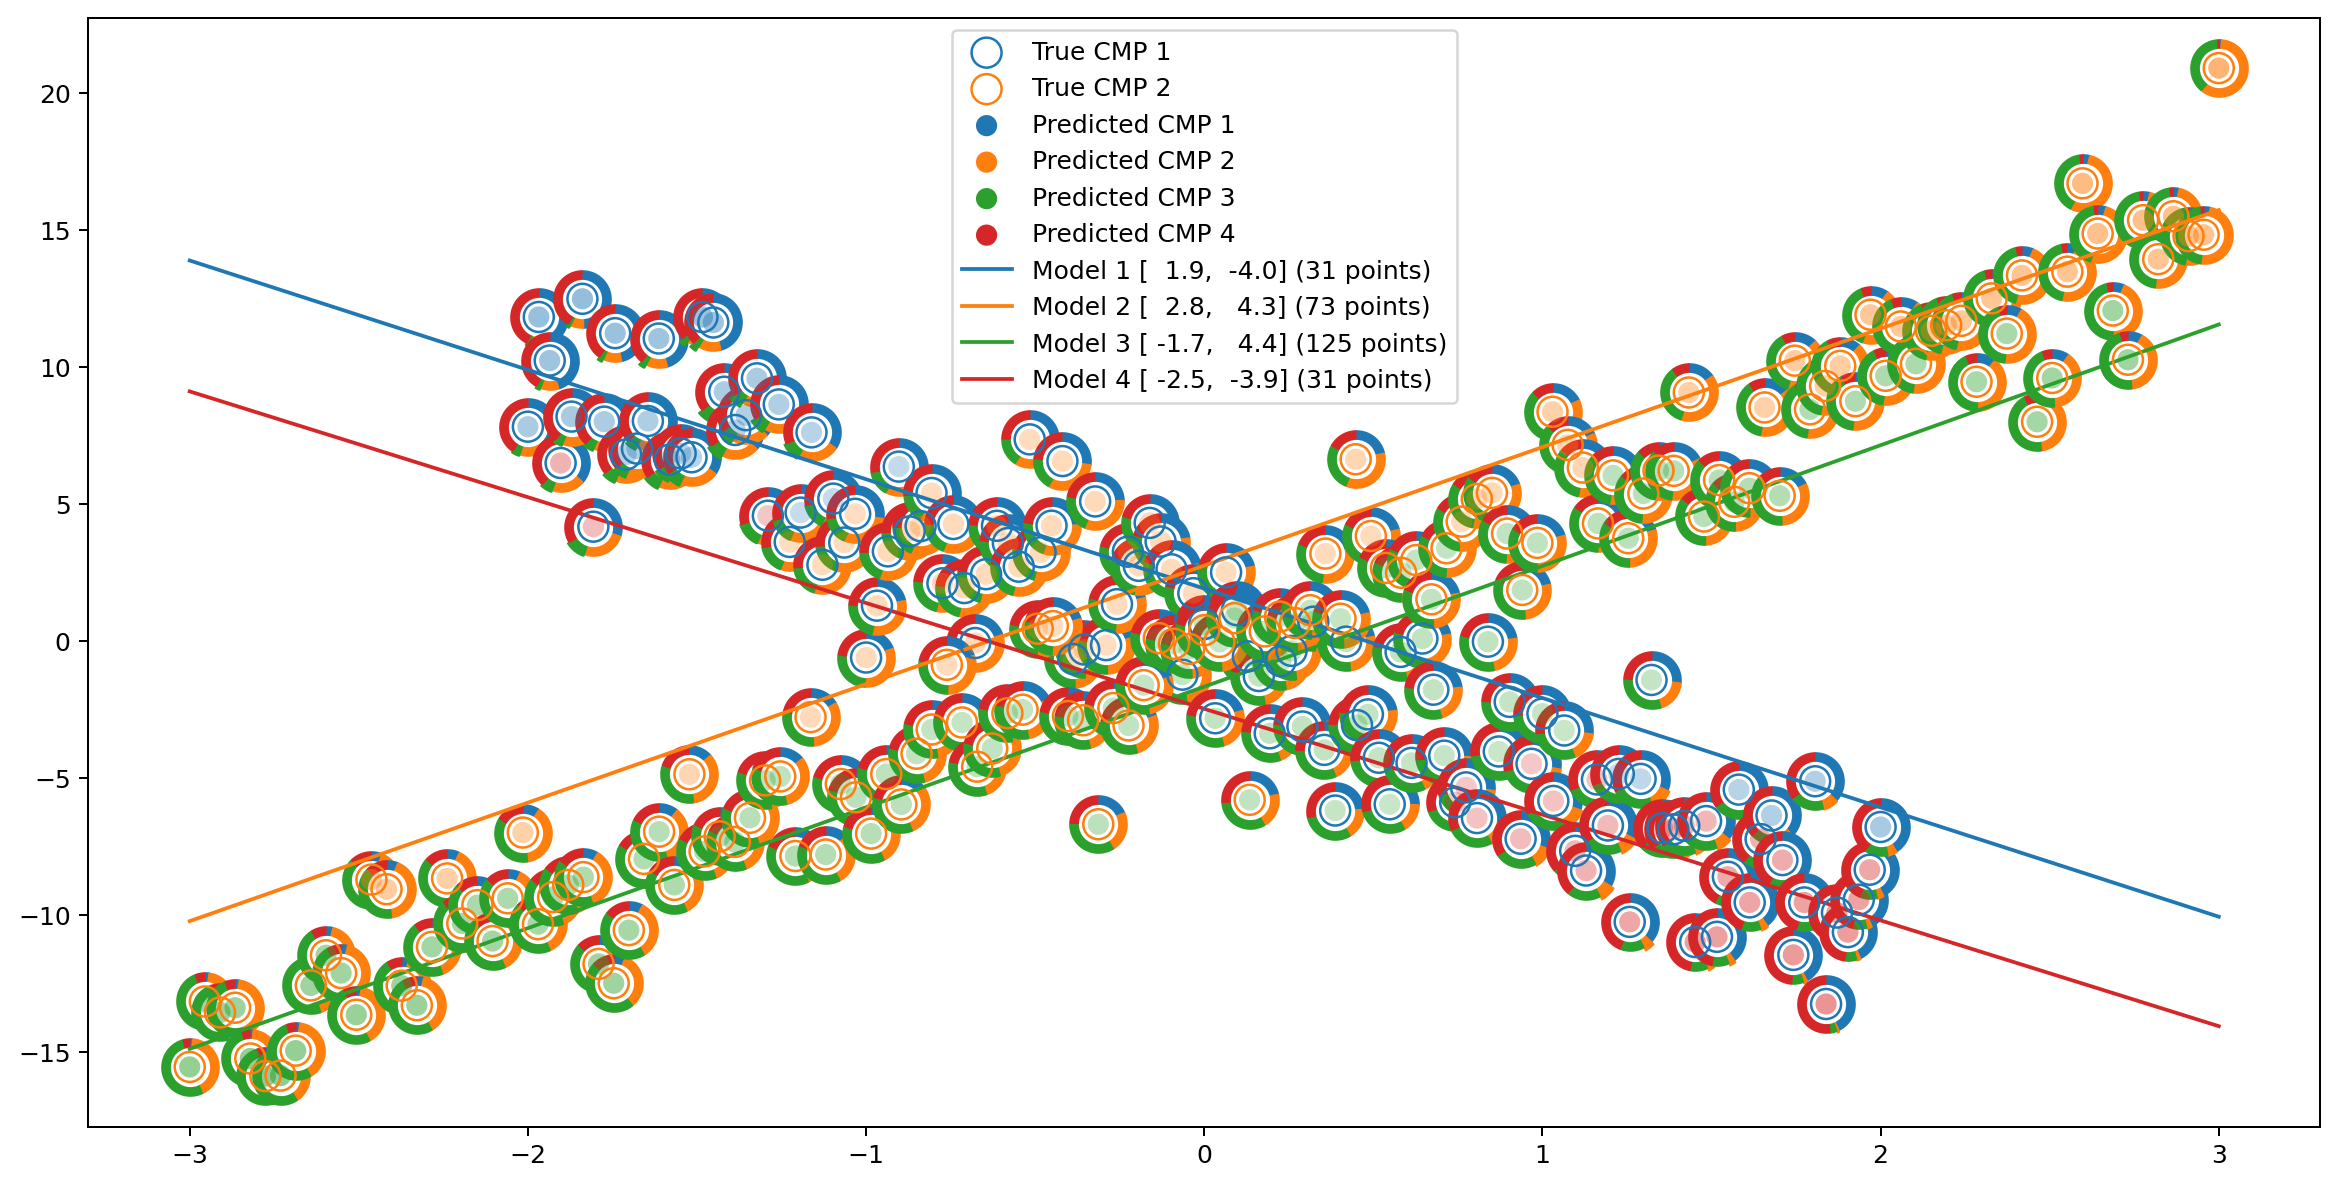

In [209]:
metric = aics
idx_best_model = np.argmin(metric)
print("BIC values: ", bics)
print("AIC values", aics)
print(f"Best model has {ncomp[idx_best_model]} components", )
print(pars_all_models)
pars = pars_all_models[idx_best_model]
print("Pars best", pars)

# xsplit, ysplit = split_data(x, y, pars)
idx_membership, p_membership = get_membership(x, y, pars)
b0s = [p[0] for p in pars]
b1s = [p[1] for p in pars]

print("Member count", np.unique(idx_membership, return_counts=True))

# RSS = np.sum((y_peak - yfit)**2)
# sigma_sq = RSS / (len(y_peak) - len(popt))
# # log-likelihood
# ll = -0.5 * len(y) * np.log(2 * np.pi * sigma_sq) - RSS / (2 * sigma_sq)
# aic = 2 * len(popt) - 2 * ll
# bic = len(popt) * np.log(len(y_peak))  -  2 * ll

p_cat = p_membership[idx_membership, np.arange(p_membership.shape[1])]

from two_models import plot_ncomp
fig = plot_ncomp((x1, x2), (y1, y2), b0s, b1s, model, idx_membership, p_cat, p_membership)


In [373]:
None in [1,2,3]

False

In [375]:
None in [1,2, [2,34]]

False